# Intro

The objective of this Notebook is to find a satisfactory modelling for FX rates. I am interested in P-"Real World probabilities". I have a 16 year daily time series and my objective is to simulate paths with a horizon of 3 years (I need at least quarterly values, but monthly would be even better).

## Mini intro to Python notebooks (Jupyter notebook)
** Jupyter Notebooks**: For those new, all this code is structured in a Jupyter notebook (former Ipython Notebook). It supports other languages (via what they call Kernel), like Julia and R (and even Octave -open source clone of Matlab-). It is a great tool for prototyping and presenting nice and organised results to other people

** Anaconda **: It's basically an "environment manager", that helps you to create an environment with the exact packages you need to execute an application, so it's easy to share. Anaconda Navigator comes with Jupyter Python installed for local use, and it has been indirectly used in this set up (see below)

** mybinder.org **: It's a free service that allows you to host Jupyter notebooks online. You need to have the Notebooks in a github repository (including with whatever data files you need), as well as a configuration file where you indicate what packages you need (a couple of formats available, I used Anaconda style). You need to tell mybinder the url of your repository and will build the environment for you, providing a link you can share


## To see all the results please go to to the menu "Cell"->"Run All" or go step by step with shift+enter over each cell

In [81]:
import pandas as pd   
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime as dt
"""
Very standard Python packages:
pandas: PANel, DAtaframe and Series package, that provides objects that can be used for estimation (time series, panel, etc.))
numpy: provides array objects, which behave similarly to Matlab matrices
matplotlib.pylab: to create and display graphs
datetime: to handle dates (provides useful functions)
"""

%matplotlib inline
#Specific instruction for Jupyter notebooks to display matplotlib charts

In [82]:
dtm = lambda x: dt.strptime(str(x), "%d/%m/%Y")
#This helps create Pandas time series based on the format of the dates in the file

In [83]:
# To follow details/explanations of the following steps, look at related notebook "Treatment of data"

df1 = pd.read_csv('EURUSD.csv', header=0, parse_dates=[0], index_col='date',date_parser=dtm)
df2 = pd.read_csv('EURGBP.csv', header=0, parse_dates=[0], index_col='date',date_parser=dtm)
df = pd.concat([df1, df2],axis=1)
print ("Number of NaN:")
print (str(df.isnull().sum()))
df = df.fillna(method='pad')  
df_rf = np.log ( df.pct_change() + 1.0)
df_rf.drop(df_rf.index[0], inplace=True)
df_rf.head()

Number of NaN:
EURUSD    1
EURGBP    0
dtype: int64


,EURUSD,EURGBP
date,,
2000-01-04,-0.005289,-0.005492
2000-01-05,-0.002320,0.001698
2000-01-06,-0.000671,0.002040
2000-01-07,0.003197,-0.001538
2000-01-10,0.003853,0.002791


_Question, I want to model with a monthly time-step, but I have daily data. What are the pifalls of doing this? I feel I shouldn't skip data -or summarise it in any way-, but on the other hand, I see a risk of not capturing long term trends (ie, mean reversion) if I project everything from daily_

Now we have the time series of potential invariants we perform the two tests
* Split series in 2 and compare histograms (expecting them to be similar)
* Plot a scatter plot of $e_{t+1}$ vs $e_t$ (expecting them to be distributed as a circle)

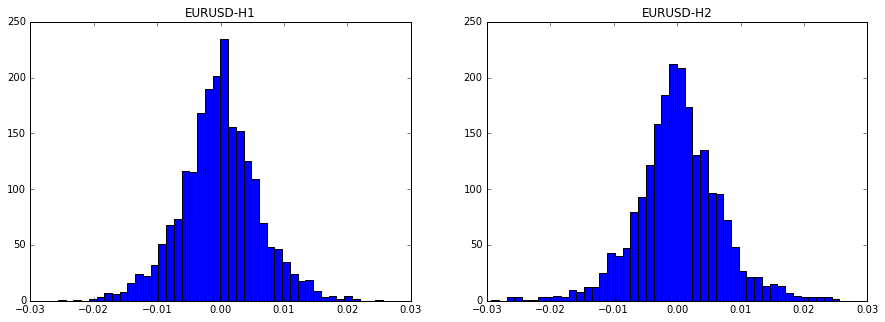

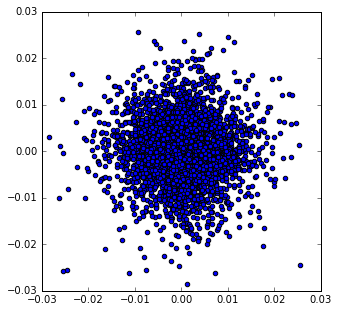

In [78]:
n_series = 1  #1 for univariate case -just for the first series-, 2 for bivariate
n_bins = 50  # to build histogram


for j in range(0,n_series):
    title = df_rf.columns[j]
    i = df_rf[title]
    #print(i)
    nLen = len(i)
    h = int(round(nLen/2,0))
        
    #maxV = np.max(i)
    #minV = np.min(i)
    maxV = max(i)
    minV = min(i)
    
    h1 = i[:h]
    h2 = i[h:]
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    
    n, bins, patches = axs[0].hist(h1, bins=n_bins, range=(minV, maxV), label="H1")
    axs[0].set_title(title + "-H1")
    axs[0].axis([-0.03,0.03,0,250])

    n, bins, patches = axs[1].hist(h2, bins=n_bins, range=(minV, maxV), label="H2")
    axs[1].set_title(title + "-H2")
    axs[1].axis([-0.03,0.03,0,250])
            
    plt.show()
    
    x1 = i[:-1]    
    x2 = i[1:]
    plt.figure(figsize=(5,5))
    plt.scatter(x1,x2)
    plt.axis([-0.03,0.03,-0.03,0.03])
    plt.show()


The question is, what to do next?
1. Fitting a distribution to the entire time series? (see normal example below) That would be assuming the invariants' structure to be a Random Walk (in particular Brownian Motion)
  1. Should I us flexible probabilities? Why yes? Why not?
2. Try to understand further how much iid the proposed $e_t$ are?  (see below)
3. What else?


### 1- Fitting distribution to the entire time series:
For the sake of the exercise I am just fitting one distribution (normal), but it's clear I should try other distributions as well

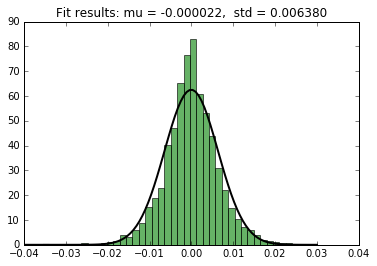

In [79]:
import scipy.stats as st
from scipy.stats import norm


for j in range(0,n_series):
    title = df_rf.columns[j]
    i = df_rf[title]
    
    # Fit a normal distribution to the data:
    mu, std = norm.fit(i)

    # Plot the histogram.
    plt.hist(i, bins=40, normed=True, alpha=0.6, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.6f,  std = %.6f" % (mu, std)
    plt.title(title)

    plt.show()

The fit is not OK (for instance, kurtosis is around 1.5). I should try to fit other distributionss (student, logistic, laplace, etc...)

### 1.A. Flexible probabilities. 
Should I find a different weighting to each individual derived invariant candidates? Why?

### 2. Should I look for stochastic properties to see if there is a better fit than a random walk?
1st idea is to do the scatter-plot of the evolution of the time series

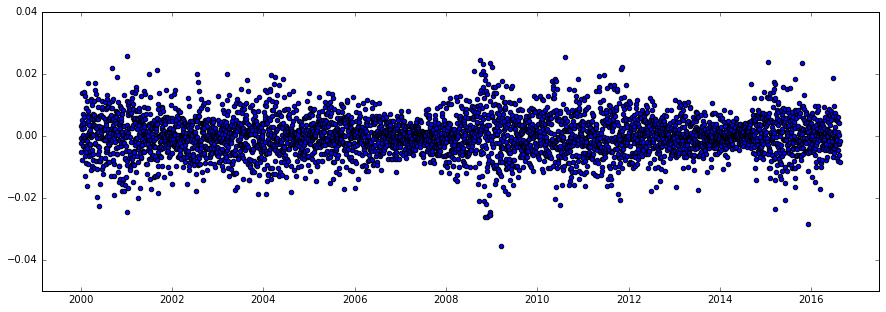

In [80]:
for j in range(0,n_series):
    title = df_rf.columns[j]
    i = df_rf[title]

    plt.figure(figsize=(15,5))
    plt.scatter (df_rf.index, i)
    plt.show()


There seems to be some volatility clustering. Should I try to fit an ARIMA(p,n,q)? A GARCH? both?